### Import Các Thư Viện Cần Thiết

In [21]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import random 
import cv2
import imutils
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

### Chuẩn Bị Dữ Liệu Huấn Luyện Và Kiểm Tra

In [22]:
# Đường dẫn tới thư mục chứa dữ liệu huấn luyện.
dir = "archive\Train"
train_data = []
img_size = 32
non_chars = ["#","$","&","@"] # Các ký tự không cần thiết

# Đọc và xử lý dữ liệu huấn luyện.
for i in os.listdir(dir): 
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 4000: # Giới hạn số lượng hình ảnh mỗi ký tự
            break
        img = cv2.imread(os.path.join(sub_directory,j),0) # Đọc ảnh ở chế độ grayscale
        img = cv2.resize(img,(img_size,img_size)) # Thay đổi kích thước ảnh
        train_data.append([img,i])

In [23]:
# Kiểm tra số lượng dữ liệu huấn luyện
len(train_data) 

140000

In [24]:
# Đường dẫn đến thư mục chứa dữ liệu xác thực
val_dir = "archive\Validation"
val_data = []
img_size = 32

# Đọc và xử lý dữ liệu xác thực
for i in os.listdir(val_dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(val_dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 1000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        val_data.append([img,i])

In [25]:
# Số lượng mẫu dữ liệu xác thực
len(val_data)

15209

In [26]:
# Xáo trộn dữ liệu
random.shuffle(train_data)
random.shuffle(val_data)

In [27]:
# Tách dữ liệu và nhãn
train_X = []
train_Y = []
for features,label in train_data:
    train_X.append(features)
    train_Y.append(label)

In [28]:
val_X = []
val_Y = []
for features,label in val_data:
    val_X.append(features)
    val_Y.append(label)

In [29]:
# Chuyển đổi nhãn thành định dạng nhị phân
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y = LB.fit_transform(val_Y)

In [30]:
# Chuẩn hóa và định hình lại dữ liệu
"""
Chia các giá trị pixel của ảnh cho 255 để đưa giá trị vào khoảng từ 0 đến 1.
Chuyển đổi hình dạng của dữ liệu ảnh để phù hợp với đầu vào của CNN.
"""
train_X = np.array(train_X)/255.0
train_X = train_X.reshape(-1,32,32,1)
train_Y = np.array(train_Y)

In [31]:
val_X = np.array(val_X)/255.0
val_X = val_X.reshape(-1,32,32,1)
val_Y = np.array(val_Y)

In [32]:
# Kích thước dữ liệu huấn luyện và xác thực
print(train_X.shape,val_X.shape)

(140000, 32, 32, 1) (15209, 32, 32, 1)


In [33]:
# Kích thước nhãn huấn luyện và xác thực
print(train_Y.shape,val_Y.shape)

(140000, 35) (15209, 35)


### **Xây dựng mô hình CNN**

#### Tạo Mô Hình Sequential
+ Thêm các lớp Conv2D (Convolutional) với activation function là ReLU.
+ Thêm các lớp MaxPooling2D để giảm kích thước không gian của các đặc trưng.
+ Thêm lớp Dropout để giảm overfitting.
+ Chuyển đổi dữ liệu sang dạng phẳng bằng Flatten.
+ Thêm lớp Dense để thực hiện phân loại.

In [34]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(35, activation='softmax'))

c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
# Hiển thị kiến trúc mô hình
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 35)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,851 (636.14 KB)

 Trainable params: 162,851 (636.14 KB)

 Non-trainable params: 0 (0.00 B)

#### Biên Dịch Mô Hình
+ Sử dụng categorical_crossentropy làm hàm mất mát.
+ Sử dụng adam optimizer.
+ Đánh giá bằng độ chính xác accuracy.

In [36]:
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

#### Huấn Luyện Mô Hình

In [37]:
''' 
Sử dụng train_X và train_Y để huấn luyện mô hình.
Kiểm tra trên tập dữ liệu val_X và val_Y.
'''
history = model.fit(train_X,train_Y, epochs=50, batch_size=32, validation_data = (val_X, val_Y),  verbose=1)

Epoch 1/50
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 137s 30ms/step - accuracy: 0.7194 - loss: 0.9208 - val_accuracy: 0.8434 - val_loss: 0.6607
Epoch 2/50
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 140s 29ms/step - accuracy: 0.8913 - loss: 0.3092 - val_accuracy: 0.8678 - val_loss: 0.6545
Epoch 3/50
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 128s 29ms/step - accuracy: 0.9049 - loss: 0.2629 - val_accuracy: 0.8632 - val_loss: 0.6748
Epoch 4/50
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 130s 30ms/step - accuracy: 0.9132 - loss: 0.2399 - val_accuracy: 0.8652 - val_loss: 0.6671
Epoch 5/50
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 130s 30ms/step - accuracy: 0.9183 - loss: 0.2213 - val_accuracy: 0.8793 - val_loss: 0.6050
Epoch 6/50
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 129s 29ms/step - accuracy: 0.9194 - loss: 0.2147 - val_accuracy: 0.8670 - val_loss: 0.7014
Epoch 7/50
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 129s 29ms/step - accuracy: 0.9232 - loss: 0.2038 - val_accuracy: 0.8831 - val_loss: 0.6162
Epoch 8/50
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 130s 30ms/step - accuracy: 

#### Lưu lại mô hình đã huấn luyện

In [38]:
model.save("huanluyen_chuviettay_model.keras")

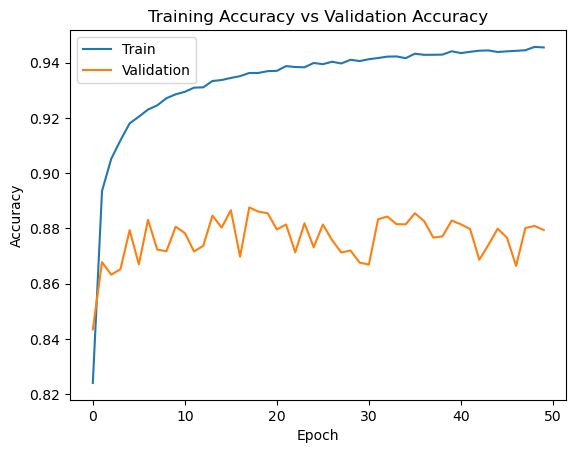

In [39]:
# Vẽ biểu đồ độ chính xác trên tập huấn luyện và tập xác thực qua các epoch.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

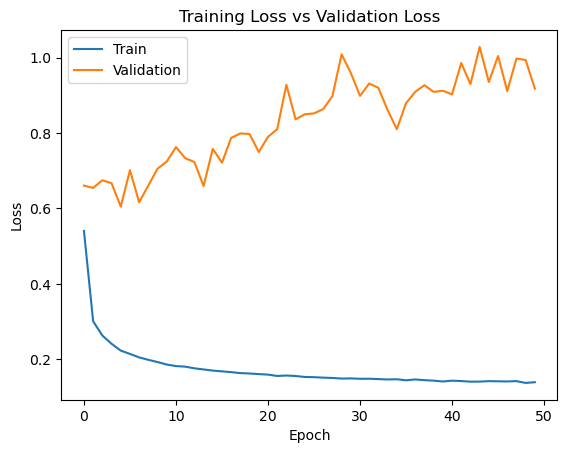

In [40]:
# Vẽ biểu đồ giá trị mất mát trên tập huấn luyện và tập xác thực
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### **Nhận Dạng Chữ Từ Hình Ảnh**

In [44]:
# Tải lại mô hình đã huấn luyện để nhận dạng.
from keras.models import load_model
model = load_model('huanluyen_chuviettay_model.keras')

#### Hàm sort_contours

In [45]:
# Sắp xếp các contours (đường viền) của ảnh theo thứ tự từ trái sang phải hoặc từ trên xuống dưới.
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts] # Tạo bounding boxes cho từng contour
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), # Sắp xếp contours và bounding boxes theo phương pháp chỉ định
    key=lambda b:b[1][i], reverse=reverse))
    # Trả về danh sách contours và bounding boxes đã sắp xếp
    return (cnts, boundingBoxes)

#### Hàm get_letters
+ Đọc ảnh và chuyển đổi sang ảnh xám (grayscale).
+ Áp dụng threshold để tạo ảnh nhị phân.
+ Giãn nở (dilate) ảnh để làm nổi bật các đặc trưng.
+ Tìm các contours của các ký tự trong ảnh.
+ Duyệt qua các contours để cắt các ký tự riêng lẻ và chuẩn hóa kích thước của chúng.
+ Dự đoán ký tự bằng mô hình đã huấn luyện.
+ Trả về các ký tự đã nhận dạng và ảnh có các ký tự được đánh dấu.

In [46]:
def get_letters(img):
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1,32,32,1)
        ypred = model.predict(thresh)
        ypred = LB.inverse_transform(ypred)
        [x] = ypred
        letters.append(x)
    return letters, image

#### Hàm get_word

In [47]:
# Ghép các ký tự lại để tạo thành từ.
def get_word(letter):
    word = "".join(letter)
    return word

#### Áp Dụng Mô Hình
+ Đọc ảnh từ tệp.  
+ Gọi hàm get_letters để nhận dạng các ký tự trong ảnh.
+ Gọi hàm get_word để tạo thành từ từ các ký tự nhận dạng được.
+ Hiển thị ảnh với các ký tự được đánh dấu và in ra từ nhận dạng được.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
UAVN7NT


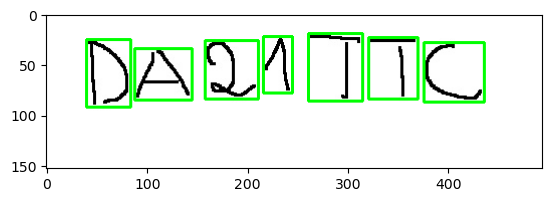

In [48]:
letter,image = get_letters("archive\dataset_thu_nghiem\DA21TTC_img.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
WTBD


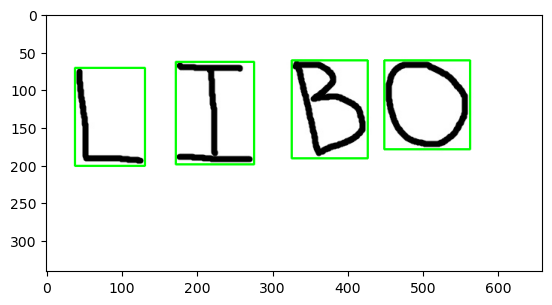

In [49]:
letter,image = get_letters("archive\dataset_thu_nghiem\Libo_img.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
HAHA


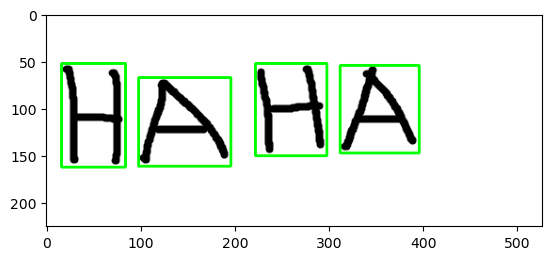

In [50]:
letter,image = get_letters("archive\dataset_thu_nghiem\haha_img.png")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
DAJNTTC


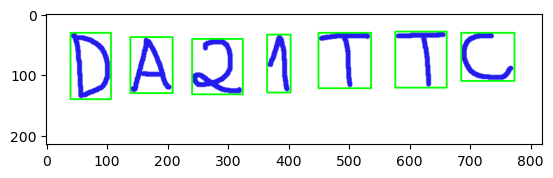

In [52]:
letter,image = get_letters("archive\dataset_thu_nghiem\DA21TTC.png")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
NZZ4


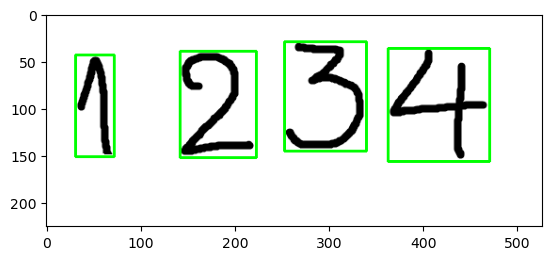

In [53]:
letter,image = get_letters("archive\dataset_thu_nghiem\h1234.png")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
TFCHZ


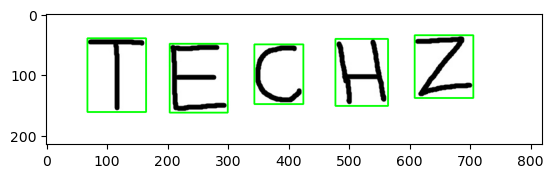

In [54]:
letter,image = get_letters("archive\dataset_thu_nghiem\TECHZ.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
YVTSHA


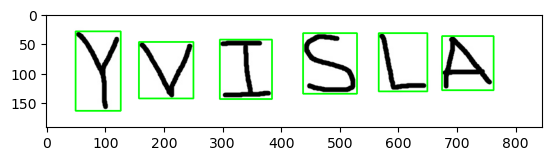

In [55]:
letter,image = get_letters("archive\dataset_thu_nghiem\YVISLA.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)